In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My Drive/

/content/drive/My Drive


In [0]:
path_img = Path('./brats_png/images')
path_lbl = Path('./brats_png/labels')

In [0]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

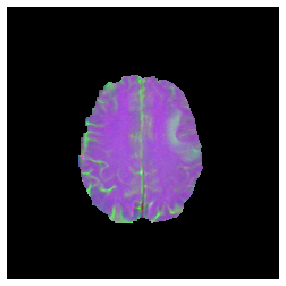

In [0]:
img_f = fnames[4]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
def get_y_fn(path):
    name = path.name
    return path_lbl/('mask_'+name)

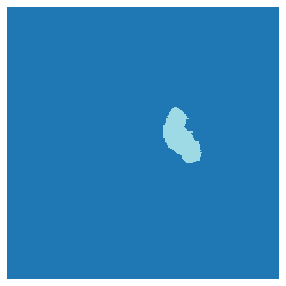

In [0]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([240, 240]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [0]:
codes = np.array(['0','1','2','3','4'], dtype='<U17')# use less than 17 bits to encode each character in each string => 16 
                                                     # why do we need this again???????
# tumor class codes
len(list(codes))

5

In [0]:
size = src_size//2

In [0]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=16
else:           bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")

using bs=16, have 15068 MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)# this collects our data into fastai list ??????
        .split_by_rand_pct(.2)
        .label_from_func(get_y_fn, classes=codes))

In [0]:
src

LabelLists;

Train: LabelList (7580 items)
x: SegmentationItemList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: SegmentationLabelList
ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240)
Path: brats_png/images;

Valid: LabelList (1895 items)
x: SegmentationItemList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: SegmentationLabelList
ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240),ImageSegment (1, 240, 240)
Path: brats_png/images;

Test: None

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)# this transforms our list of images into what ???????
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
data

ImageDataBunch;

Train: LabelList (7580 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: brats_png/images;

Valid: LabelList (1895 items)
x: SegmentationItemList
Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120),Image (3, 120, 120)
y: SegmentationLabelList
ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120),ImageSegment (1, 120, 120)
Path: brats_png/images;

Test: None

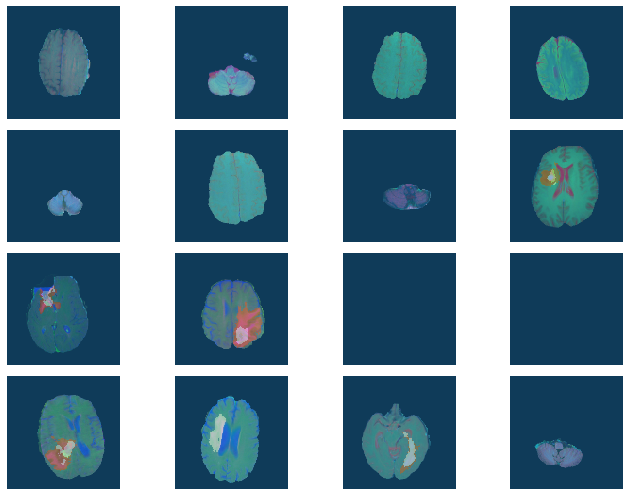

In [0]:
data.show_batch(4, figsize=(10,7))# this shows us a batch of what type of images ???????

In [0]:
name2id = {v:k for k,v in enumerate(codes)}

In [0]:
void_code = name2id['0']

In [0]:
def acc_classwise(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()# why do they need to be floating pts ??????

In [0]:
metrics = acc_classwise

In [0]:
wd =1e-2

In [0]:
learn = unet_learner(data, models.resnet50, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 29.5MB/s]


In [0]:
lr=3e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_classwise,time
0,0.029111,0.024839,0.330450,1:23:32
1,0.022276,0.023739,0.323115,08:57
2,0.021362,0.018043,0.581657,08:49
3,0.020427,0.016716,0.625652,08:44
4,0.021608,0.017775,0.572800,08:39
5,0.350161,0.033714,0.159612,08:36
6,0.023126,0.021284,0.464602,08:32
7,0.020515,0.017754,0.611279,08:32
8,0.019133,0.017791,0.526095,08:32
9,0.014358,0.012924,0.691121,08:32


In [0]:
learn.save("brats_fastai_1", return_path=True)

PosixPath('brats_png/images/models/brats_fastai_1.pth')

In [0]:
msk_true = learn.data.train_ds[321][1]
img = learn.data.train_ds[321][0]

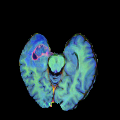

In [0]:
img

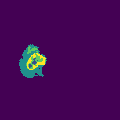

In [0]:
msk_true

In [0]:
pred = learn.predict(img)[0]

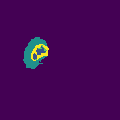

In [0]:
res[0]